# Build train and test matrices

In [1]:
import pandas as pd
import numpy as np
import feather

df = (feather.read_dataframe('/home/SHARED/SOLAR/data/oahu_min.feather')
             .set_index('Datetime'))

In [2]:
# https://stackoverflow.com/questions/15722324/sliding-window-in-numpy
def window_stack_forward(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0, width) )

In [3]:
# I feel this function can also be done for pd.DataFrame
def window_stack(a, width=3):
    n = a.shape[0]
    return np.hstack(list(a[(width-1-i):(n-i)] for i in range(0, width)))

In [4]:
# In pandas 0.24, use df.to_numpy() instead of df.values. Also care with non-numeric columns
width = 61
a = window_stack(df.values, width=width)

In [5]:
times   = [ ('t' if not idx else 't-{:d}'.format(idx)) for idx in range(width) ]
columns = pd.MultiIndex.from_product((times, df.columns), names=('time', 'location'))

In [6]:
# Convert back to DataFrame, just for convenience of having indexes
df_roll = pd.DataFrame(a, index=df.index[width-1:], columns=columns)

In [7]:
# Split target (time t) and variables (times t-1 to t-width+1)
y = df_roll['t']
X = df_roll.drop(columns='t', level='time')

In [8]:
# Split train-test, approximately 12 and 4 months respectively
X_train, X_test = X[:'2011-07-31'], X['2011-08-01':]
y_train, y_test = y[:'2011-07-31'], y['2011-08-01':]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(449885, 1140)
(82892, 1140)
(449885, 19)
(82892, 19)


# Naive predictor

We compute the error while predicting with the inmediately previous observation, for each sensor

In [10]:
y_pred = np.zeros_like(y_test.values)
y_pred = X_test['t-1']

In [11]:
y_pred.columns

Index(['GH_DH3', 'GH_DH4', 'GH_DH5', 'GH_DH10', 'GH_DH11', 'GH_DH9', 'GH_DH2',
       'GH_DH1', 'GT_DH1', 'GH_AP6', 'GT_AP6', 'GH_AP1', 'GH_AP3', 'GH_AP5',
       'GH_AP4', 'GH_AP7', 'GH_DH6', 'GH_DH7', 'GH_DH8'],
      dtype='object', name='location')

In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mae = pd.Series(mae, index=y_test.columns)
mae.sort_values()

location
GH_AP3      0.000000
GT_DH1     43.546326
GT_AP6     45.910107
GH_DH2     55.875255
GH_DH1     56.050096
GH_DH4     56.824072
GH_AP7     57.005657
GH_DH11    57.096757
GH_DH10    57.214625
GH_DH8     57.261513
GH_DH7     57.296253
GH_AP4     57.439284
GH_DH5     57.471329
GH_AP1     57.739932
GH_DH6     58.379390
GH_AP5     58.714546
GH_DH9     59.378966
GH_DH3     60.004030
GH_AP6     60.582939
dtype: float64

# Convolutional predictor


In [14]:
# First test: we only use the previous timestep as features
X_tr1 = X_train['t-1']
y_tr1 = y_train

X_te1 = X_test['t-1']
y_te1 = y_test

In [15]:
info = pd.read_csv('/home/SHARED/SOLAR/data/info.csv')

In [16]:
info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))

In [17]:
info.index = info.Location

In [18]:
longs = info['       Longitude'].sort_values(ascending=False)

In [19]:
longs

Location
AP7    -158.07785
AP6    -158.07935
AP4    -158.07947
AP3    -158.08163
AP5    -158.08249
AP1    -158.08389
DH5    -158.08424
DH3    -158.08463
DH4    -158.08505
DH11   -158.08530
DH2    -158.08534
DH10   -158.08554
DH8    -158.08675
DH6    -158.08678
DH7    -158.08685
DH9    -158.08688
DH1    -158.08700
Name:        Longitude, dtype: float64

In [20]:
X_tr1.drop('GT_AP6', inplace=True, axis=1)
y_tr1.drop('GT_AP6', inplace=True, axis=1)

/home/victor/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
X_tr1.drop('GT_DH1', inplace=True, axis=1)
y_tr1.drop('GT_DH1', inplace=True, axis=1)

/home/victor/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
X_te1.drop('GT_AP6', inplace=True, axis=1)
y_te1.drop('GT_AP6', inplace=True, axis=1)
X_te1.drop('GT_DH1', inplace=True, axis=1)
y_te1.drop('GT_DH1', inplace=True, axis=1)

/home/victor/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
X_tr1.shape, y_tr1.shape

((449885, 17), (449885, 17))

In [24]:
homogen_name = lambda x: x[-4:].replace('_', '')

X_tr1.columns = [homogen_name(x) for x in X_tr1.columns.values.tolist()]
y_tr1.columns = [homogen_name(x) for x in y_tr1.columns.values.tolist()]

In [25]:
homogen_name = lambda x: x[-4:].replace('_', '')

X_te1.columns = [homogen_name(x) for x in X_te1.columns.values.tolist()]
y_te1.columns = [homogen_name(x) for x in y_te1.columns.values.tolist()]

In [801]:
# This should be inside the generator...

X_tr1_1 = X_tr1[longs.index]
y_tr1_1 = y_tr1[longs.index]

In [805]:
#X_tr1_1['ts'] = X_tr1_1.index
#X_tr1_1.ts.dt.dayofyear

In [806]:
# This should be inside the generator...

X_te1_1 = X_te1[longs.index]
y_te1_1 = y_te1[longs.index]

In [807]:
# Some other ordenations...

In [808]:
def generator(batch_size):
    while True:
        for ((_,g),(_,gy)) in zip( X_tr1_1.groupby(np.arange(len(X_tr1_1))//batch_size), y_tr1_1.groupby(np.arange(len(y_tr1_1))//batch_size)):
            # Perform channeling here
            
            yield (g.values,gy['AP5'].values)
            
for g,v in generator(2):
    print(g, v)
    print(g.shape, v.shape)
    break

[[872.649 854.032 852.806 872.566 873.924 876.666 881.786 900.766 886.728
  767.687 886.599 886.013 788.85  883.372 906.51  881.742 900.617]
 [867.215 852.863 850.657 868.076 870.454 874.832 882.485 901.238 886.335
  873.668 888.742 880.241 896.622 904.673 896.193 920.883 873.728]] [870.454 870.456]
(2, 17) (2,)


In [809]:
n_sensors = 17
sensor = 'AP3'  
index_sensor = 3

sensor = 'AP5'  # 'AP5' initial
index_sensor = 4

X_tr1_1_np = X_tr1_1.values
y_tr1_1_np = y_tr1_1[sensor].values

y_tr1_1_np_list = [y_tr1_1.values[:,i] for i in range(n_sensors)]

In [810]:
X_te1_1_np = X_te1_1.values
y_te1_1_np = y_te1_1[sensor].values

y_te1_1_np_list = [y_te1_1.values[:,i] for i in range(n_sensors)]

In [811]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add, Multiply, Subtract, Dropout
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected1D, Conv1D, UpSampling1D, MaxPooling1D, Dot, Concatenate

from keras import backend as K

In [812]:
xin = Input(shape=(n_sensors,1), name='main_input')
x = LocallyConnected1D(8, 5, data_format = 'channels_last', padding='valid')(xin)
x = MaxPooling1D()(x)  # potentially bad?


hard = False

if hard: # fuck this branch
    x = Conv1D(2, 3, data_format = 'channels_last', padding='causal')(x)
    x = UpSampling1D()(x)
    x = Conv1D(1, 3, data_format = 'channels_last', padding='causal')(x)
    x = UpSampling1D()(x)
    x = LocallyConnected1D(1, 4, data_format = 'channels_last', padding='valid')(x)
    #x = Flatten()(x)
    #x = Dense(1)(x)
    xo = Activation('relu')(x)

    # this is to compute the loss per sensor:
    xoo = [Lambda(lambda x : x[:,i,:], name='sensor_'+str(i)+'_'+str(longs.index[i]))(xo) for i in range(n_sensors)]
else:
    x = Activation('relu')(x)
    
    x = Conv1D(2, 3, data_format = 'channels_last', padding='causal')(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    x = Dense(n_sensors)(x)
    x = Reshape((n_sensors, 1)) (x)
    xo = Activation('relu')(x)
    xoo = [Lambda(lambda x : x[:,i,:], name='sensor_'+str(i)+'_'+str(longs.index[i]))(xo) for i in range(n_sensors)]
    
    # Add residual connection with input in order to learn persitence?


model = Model(inputs=[xin], outputs=xoo)

In [818]:
# causal better

xin = Input(shape=(n_sensors,1), name='main_input')
x = LocallyConnected1D(8, 7, data_format = 'channels_last', padding='valid')(xin)
x = Activation('relu')(x)
x = LocallyConnected1D(16, 5, data_format = 'channels_last', padding='valid')(x)
x = Activation('relu')(x)
x = Conv1D(32, 3, data_format = 'channels_last', padding='causal')(x)
xl = Flatten()(x)
xl = Dropout(0.2)(xl)
xo = Dense(1)(xl)


# use date info here?
xinf = Flatten()(xin)
s  = Dense(5)(xinf)
s = Activation('tanh')(s)
s = Dense(2)(s)
s = Activation('softmax')(s)


xin_0 = Activation('relu')(xin)
xin_1 = Lambda(lambda x : x[:,index_sensor,:])(xin_0)
xo_m = Dot(axes=1)([Concatenate()([xo,xin_1]), s])
# instead of this, use a residual connection

xom = Add()([xo, xin_1])

# better than just residual (xom)
xo_m = Activation('relu')(xo_m)


model = Model(inputs=[xin], outputs=[xo_m])

In [819]:
opt = keras.optimizers.Adam(lr=0.0001)

In [820]:
#losses = ['mean_absolute_error'] * n_sensors
#model.compile(opt, loss=losses)
model.compile(opt, loss='mean_absolute_error')

In [821]:
c1 = keras.callbacks.BaseLogger(stateful_metrics=None)
c2 = keras.callbacks.ReduceLROnPlateau(patience=3)
c2 = CyclicLR(step_size=250, base_lr=0.0001)

In [ ]:
batch_size = 1 << 11   # as big as possible so we can explore many models
epochs = 1 << 11
model.fit(np.atleast_3d(X_tr1_1_np), y_tr1_1_np, batch_size=batch_size, epochs=epochs, validation_data=
          (np.atleast_3d(X_te1_1_np),y_te1_1_np), callbacks=[c1, c2])


Train on 449885 samples, validate on 82892 samples
Epoch 1/2048
 10240/449885 [..............................] - ETA: 3:09 - loss: 168.6659

/home/victor/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.875416). Check your callbacks.
  % delta_t_median)


449885/449885 [==============================] - 17s 37us/step - loss: 64.0640 - val_loss: 45.3073
Epoch 2/2048
449885/449885 [==============================] - 11s 23us/step - loss: 46.5949 - val_loss: 41.7792
Epoch 3/2048
449885/449885 [==============================] - 11s 24us/step - loss: 45.6498 - val_loss: 42.0581
Epoch 4/2048
449885/449885 [==============================] - 11s 24us/step - loss: 45.4986 - val_loss: 41.2992
Epoch 5/2048
449885/449885 [==============================] - 11s 24us/step - loss: 44.7784 - val_loss: 40.7198
Epoch 6/2048
449885/449885 [==============================] - 10s 23us/step - loss: 44.7606 - val_loss: 40.7064
Epoch 7/2048
449885/449885 [==============================] - 11s 24us/step - loss: 44.3997 - val_loss: 40.5302
Epoch 8/2048
449885/449885 [==============================] - 10s 23us/step - loss: 44.5682 - val_loss: 41.3216
Epoch 9/2048
449885/449885 [==============================] - 11s 24us/step - loss: 44.3154 - val_loss: 40.5269
Epoch

In [744]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 17, 1)        0                                            
__________________________________________________________________________________________________
locally_connected1d_240 (Locall (None, 11, 8)        704         main_input[0][0]                 
__________________________________________________________________________________________________
activation_460 (Activation)     (None, 11, 8)        0           locally_connected1d_240[0][0]    
__________________________________________________________________________________________________
locally_connected1d_241 (Locall (None, 7, 16)        4592        activation_460[0][0]             
__________________________________________________________________________________________________
activation

In [461]:
# as big as possible so we can explore many models
batch_size = 1 << 11   
epochs = 1 << 6
model.fit(np.atleast_3d(X_tr1_1_np), y_tr1_1_np_list, batch_size=batch_size, epochs=epochs, validation_data=
          (np.atleast_3d(X_te1_1_np),y_te1_1_np_list), callbacks=[c1, c2], verbose=2)

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 17 arrays: [array([[867.215],
       [860.998],
       [844.272],
       ...,
       [  0.   ],
       [  0.   ],
       [  0.   ]]), array([[852.863],
       [845.067],
       [838.051],
       ...,
       [  0...

TypeError: must be str, not int

In [208]:
# AP5 40.5219

In [319]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 17, 1)        0                                            
__________________________________________________________________________________________________
locally_connected1d_88 (Locally (None, 11, 8)        704         main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_30 (MaxPooling1D) (None, 5, 8)         0           locally_connected1d_88[0][0]     
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 5, 2)         50          max_pooling1d_30[0][0]           
__________________________________________________________________________________________________
up_samplin

# Train Elastic Net model

In [10]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def timer(tag=None):
    start = default_timer()
    try:
        yield
    finally:
        end = default_timer()
        print(('[{}] '.format(tag) if tag else '') +
               'Elapsed time (s): {:.6f}'.format(end - start))

In [11]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

enet = ElasticNetCV(n_jobs=10, cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5)
with timer():
    enet.fit(X_train, y_train['GH_AP1'])

Elapsed time (s): 646.287442


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [12]:
print('R^2 (train): {}'.format(enet.score(X_train, y_train['GH_AP1'])))
print('R^2 (test): {}'.format(enet.score(X_test, y_test['GH_AP1'])))
print('alpha: {}'.format(enet.alpha_))
print('l1_ratio: {}'.format(enet.l1_ratio_))

R^2 (train): 0.8996642313321442
R^2 (test): 0.8810550943484787
alpha: 229.09871455104192
l1_ratio: 0.5


In [13]:
%matplotlib inline
res = pd.DataFrame({'Actual': y_test['GH_AP1'], 'Pred': enet.predict(X_test)})

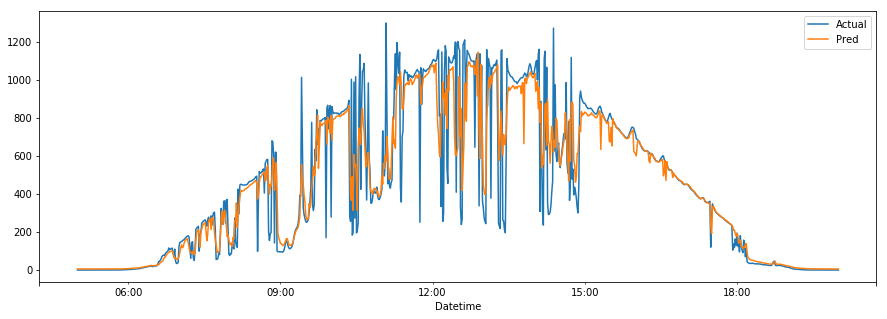

In [14]:
res['20110801'].plot(figsize=(15, 5));

In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
res['abs_error'] = res['Actual'].sub(res['Pred']).abs()

In [17]:
res['abs_error'].mean()

56.42577223776865

In [18]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor

enet = MultiOutputRegressor(ElasticNetCV(cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5), n_jobs=10)
with timer():
    enet.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Elapsed time (s): 4048.463773


In [27]:
y_test_pred = pd.DataFrame(enet.predict(X_test), index=y_test.index, columns=y_test.columns)

In [32]:
res = pd.concat((y_test, y_test_pred), axis=1, keys=['Actual', 'Pred'])

In [45]:
res.stack(level='location').groupby('location').apply(lambda s: mean_absolute_error(s['Actual'], s['Pred'])).sort_values()

location
GH_AP3     41.272833
GH_DH8     45.940841
GH_DH11    49.423486
GH_AP5     49.645268
GT_DH1     50.232415
GH_DH9     51.914226
GH_DH6     52.295803
GH_DH10    54.067657
GT_AP6     54.362009
GH_DH7     55.919909
GH_AP1     56.425772
GH_DH4     57.001618
GH_DH5     57.469298
GH_DH3     58.028241
GH_DH1     59.039559
GH_DH2     60.615344
GH_AP4     62.791843
GH_AP6     68.239365
GH_AP7     71.464025
dtype: float64

Conclusiones:
* Ajustar los 19 modelos ENet tarda poco más de 1h con `n_jobs=10`
* Parece que hay bastantes diferencias entre estaciones

**TODO**:
* Hacer un mapa de las estaciones coloreado por MAE, a ver si tienen alguna distribución espacial
* Probar otros modelos
* Normalizar las series temporales entre [0, 1]?
* Probar con distintos valores de `width`, como si fuera un hiperparámetro
* Ver sparsity
* Ajustar otros modelos (RandomForest, GradientBoosting, Neural Networks)

In [47]:
df.describe()

,GH_DH3,GH_DH4,GH_DH5,GH_DH10,GH_DH11,GH_DH9,GH_DH2,GH_DH1,GT_DH1,GH_AP6,GT_AP6,GH_AP1,GH_AP3,GH_AP5,GH_AP4,GH_AP7,GH_DH6,GH_DH7,GH_DH8
count,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000,532837.000000
mean,376.638750,370.034010,373.901195,374.273224,371.089837,374.772595,370.716366,369.618733,315.318571,375.733485,308.801022,369.002688,322.606723,373.845794,370.204234,375.590406,374.534719,376.029534,370.716376
std,362.964985,350.421419,354.759126,353.021138,351.115238,363.056479,351.535268,349.439053,352.513236,355.910431,336.893122,347.831176,295.782851,355.027967,348.719699,357.166830,354.640874,356.311609,351.467618
min,-0.472400,-0.392927,-0.350097,-0.361164,-0.386116,-0.472512,-0.711078,-0.358951,-0.409680,-0.390316,-0.364171,0.000000,0.000000,0.000000,-0.358721,-0.389675,-0.383402,-0.382509,-0.392466
25%,35.866100,39.654200,39.543000,40.775900,38.551100,35.411500,36.950300,36.569700,29.477700,39.798900,33.856200,40.013500,138.069000,39.775800,40.156700,37.754700,39.172700,40.141100,39.567900
50%,274.736000,276.848000,278.847000,281.729000,278.481000,271.122000,276.924000,277.451000,166.047000,281.771000,174.568000,278.183000,234.346000,279.015000,279.661000,279.862000,280.325000,280.463000,277.053000
75%,635.739000,624.226000,630.812000,631.830000,625.551000,633.216000,626.999000,625.359000,530.037000,633.694000,511.336000,622.964000,424.807000,629.598000,624.808000,635.345000,632.643000,635.162000,624.791000
max,1666.880000,1700.350000,1655.720000,1651.900000,1627.110000,1697.560000,1699.410000,1588.720000,1587.020000,1580.340000,1542.840000,1593.990000,1657.880000,1648.220000,1574.890000,1612.970000,1584.890000,1627.860000,1610.440000


In [665]:
from keras.callbacks import *


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())